In Lab 5 we will be using this Jupyter notebook to explore sampling, digital processing, and software-based envelpe detection procedures to augment the analog AM detection procedures examined in Lab 4.

Jupyter notebooks enable step-by-step access to python code snippets enclosed in "cells". Each time you excute a code cell, by selecting the cell and pressing "Shift+Enter", the code embedded within the cell is executed to produce some outputs including graphical outputs. Some cells will be required to be excuted multiple times and some of them require entering parameters before excuting. To learn more about Jupyter notebook, please see the link below. 

https://jupyter-notebook.readthedocs.io/en/stable/notebook.html

Excecute the next cell to import some useful python packages that we will be needing for computations and graphics

In [3]:
%pylab inline
from scipy.io import wavfile
from scipy.signal import butter, lfilter, freqz,firwin
import numpy as np
from IPython.lib.display import Audio

Populating the interactive namespace from numpy and matplotlib


/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


The functions that are used in the rest of this notebook are defined in the following cell. Understanding them is not necessary to finish this lab, but if you are curious or want to make changes feel free to explore this cell. If you break the the functions don't worry, you may always re-download the code from the course website to reset the changes.

In [4]:
# define contants
fs = 44100.0 # Sampling rate used in computer, Hz
fs_high = 44100*10 # high sampling rate 
T = 0.1
nyq_rate = fs/2
time_display = 1 #ms 


# Utilities function 
def sampling(test_signal):
    # downsampling function by factor of 10 
    signal_sampled = test_signal[::10]
    return signal_sampled

def create_sinusoid(f,fs=fs_high,T=T):
    # create sinusoid function of given frequency and time duration 
    t = np.linspace(0,T,int(T*fs)) 
    test_signal = cos(2*pi*f*t)*0.2
    return test_signal

def create_square(f,fs=fs_high,T=T):
    # create square function of given frequency and time duration 
    t = np.linspace(0, T, int(T*fs), endpoint=False)
    x = cos(2*pi*f*t)*0.2
    test_signal=sign(x)    
    return test_signal

def create_AM(f_c=13000,f_m=880,fs=fs_high,T=T):
    # create AM signal of given carrier frequency f_c and time duration, assuming message is sine with frequency of f_m 
    t = linspace(0, T, int(T*fs), endpoint=False)
    test_signal = sin(2*pi * f_c * t)*(sin(2*pi * f_m * t)+2)
    return test_signal

def create_bandpass_filter(fc_low,fc_high):
    # create bandpass filter at given cutoff frequencies, the order is default to be 127
    cutoff_hz = array([fc_low,fc_high])
    n = 127
    taps = firwin(n,cutoff_hz/nyq_rate,pass_zero=False)
    return taps


def low_pass_filter(cut_off):
    # return impulse response of a low pass filter with given cut off frequency
    fc_low = cut_off
    cutoff_hz = array([fc_low])
    n = 127
    taps_lpf = firwin(n,cutoff_hz/nyq_rate)
    return taps_lpf

def Envelope_Detector(f):
    # return output of an envelope dector with given input
    f_abs = abs(f)
    cut_off = 4e3
    taps_lpf = low_pass_filter(cut_off)
    y_envelope = convolve(f_abs,taps_lpf)
    return y_envelope

def Coherent_Detector(f):
    # return output of an envelope dector with given input
    L = len(f)
    t = linspace(0,L/fs,L)
    fft_len = 2**16
    
    if L > fft_len:
        f_fft = abs(fft.fft(f,fft_len))
        carrier_freq = argmax(f_fft[:int(fft_len/2)])/fft_len*fs
    else :
        
        f_fft = abs(fft.fft(f,L))
        carrier_freq = argmax(f_fft[:int(L/2)])/L*fs
    f_demod = f*sin(carrier_freq*2*pi*t)
    cut_off = 4e3
    taps_lpf = low_pass_filter(cut_off)
    y_coherent = convolve(f_demod,taps_lpf)
    return y_coherent


#Display auxiliary function 
def freq_response(impulse_response):
    # show frequency response of given impulse response
    w, h = freqz(impulse_response, worN=8000)
    plot((w/pi)*nyq_rate/1000, (abs(h)), linewidth=2)
    xlabel("Frequency / kHz")
    ylabel("Magnitude / rms")
    title("Filter frequency response")    
    
    
def time_domain_display_stem(test_signal):
    # create stem for given time display interval, assuming low sampling rate
    test_signal = roll(test_signal,200)
    npts_display = round(time_display*fs/1000)    
    t_axis = linspace(0,time_display,npts_display)
    stem(t_axis,test_signal[:npts_display])
    xlabel("Time / ms")
    ylabel("Amplitude")
    
def time_domain_display_plot(test_signal):
    # create plot for given time display interval, assuming high sampling rate
    test_signal = roll(test_signal,2000)
    npts_display = round(time_display*fs_high/1000)    
    t_axis = linspace(0,time_display,npts_display)
    plot(t_axis,test_signal[:npts_display])
    xlabel("Time / ms")
    ylabel("Amplitude")
    
def freq_domain_display(test_signal,unit="rms"):
    # create Fourier transform spectrum for positive frequency, assuming low sampling rate
    npts_display = int(len(test_signal)/2)
    
    if npts_display  >2**15:
        npts_display = 2**15
    

    y_fft = fft.fft(test_signal,npts_display*2)
    
    freq_display = fs/2/1000
    freq_axis = linspace(0,freq_display,npts_display)
    if unit == "rms":
        plot(freq_axis,abs(y_fft)[:npts_display])
        ylabel("Magnitude / rms")
    else :
        plot(freq_axis,20*log10(abs(y_fft)[:npts_display]))
        ylabel("Magnitude / dB")
    xlabel("Frequency / kHz")
    title("Magnitude vs Frequency (kHz)")

# 1. Downsampling and aliasing

Computers can only process sampled digital signals or data, but with sufficiently dense sampling computation results can be displayed as if they were analog (continuous) data, just like Scopy's "Fourier transform" plots that we saw in the previous lab.  

In Python we can either use the "plot" function to dispay discrete data as if they form a continuous curve or uste the "stem" function to display the collection of individual samples --- we next define a sinusoidal wave and display if using both "plot" and "stem" functions to see the difference! 

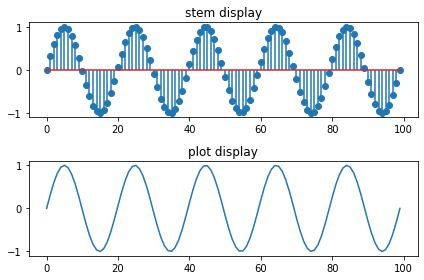

In [5]:
t = linspace(0,1,100)
f_t = sin(2*pi*t*5)
subplot(2,1,1)
stem(f_t)
title("stem display")
subplot(2,1,2)
plot(f_t)
title("plot display")
tight_layout()

As you see above, the same discrete signal can be displayed differently using different plotting functions. The "plot" function is often used when the trending of signal is more interested while the "stem" function focuses on each individual sample. In this lab, in order to demonstrate the sampling effect using digital signal only, we will use 441000 Hz for high sampling rate and 44100 Hz for the normal sampling rate. The aliasing effect would still happen when the underlying frequency in the high sampling rate signal is higher than half of the sampling rate. 

We will use "plot" function when displaying the high sampling rate signal as if it were continuous signal, and use "stem" function to display the sampled signal. 

<img src="system_diagram.png" width="600">

Input signal  $f(t)$ is first sampled at 44100 Hz and the sampled signal $f(nT)$ is then fed into the "System" to generate an output $y(nt)$ --- the system hidden in the box could be a "band pass filter" or an "envelope detector" or even the combination of both depending on applications. In our first set of applications next，the system will be an "all pass" described by $f(nT)=y(nT)$

Let's first generate the input signal $f(t)$. You will be using one of the provided functions above to create a cosine function with frequency of 2 kHz. 

Input the desired frequency for testing signal in the next cell.  

In [6]:
f = 2000   # Hz, fill the number 2000 here and excute this cell 

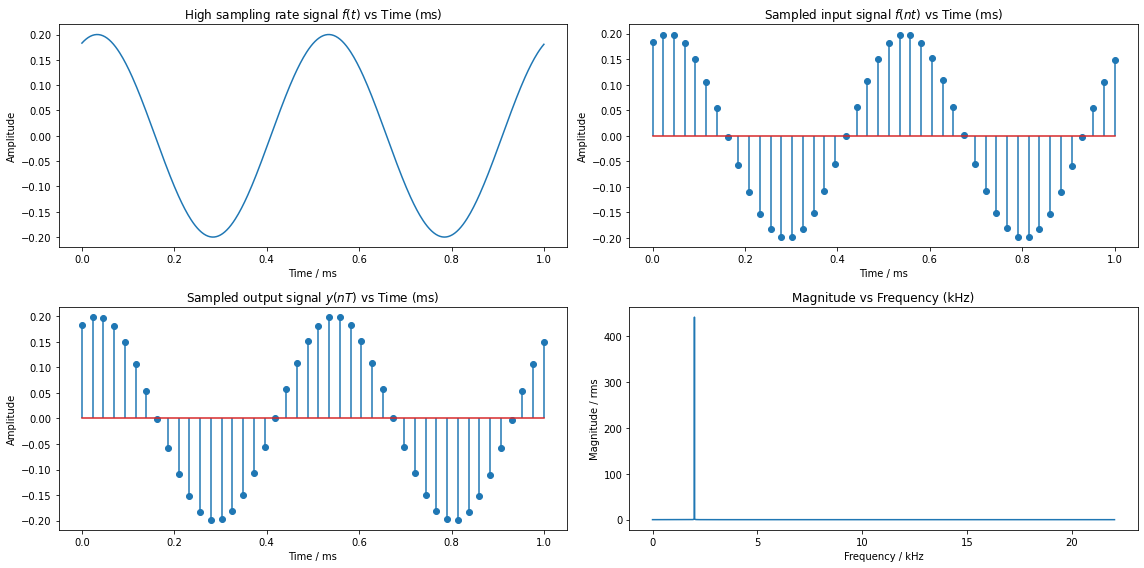

In [7]:
f_t = create_sinusoid(f,fs_high)
f_nT = sampling(f_t)
y_nT = f_nT
figure(figsize=(16,8))
subplot(2,2,1)
time_domain_display_plot(f_t)
title("High sampling rate signal $f(t)$ vs Time (ms)")
subplot(2,2,2)
time_domain_display_stem(f_nT)
title("Sampled input signal $f(nt)$ vs Time (ms)")
subplot(2,2,3)
time_domain_display_stem(y_nT)
title("Sampled output signal $y(nT)$ vs Time (ms)")
subplot(2,2,4) 
freq_domain_display(f_nT)
tight_layout()

We are next posing for you a number of questions we are expecting you to answer based on your interpretation of cell outputs from above and below. All the questions are written in bold font with a question number in front of them as you see below. The answers to these questions should be entered in lab5.pdf --- using pen or pencil on a printout of the pdf or using a tablet to write directly on the pdf document.  

### 1.1 Describe what you see in time domain of the sampled input signal (top right plot)

### 1.2 Describe what you see in frequency domain of the ouput (bottom right plot)

Next run the following two cells in succession several times using different input frequency f in the 2 kHz to 20 kHz range. Based on your observations you will be asked to answer several questions afterwards.

In [8]:
f = 24000  # Hz 

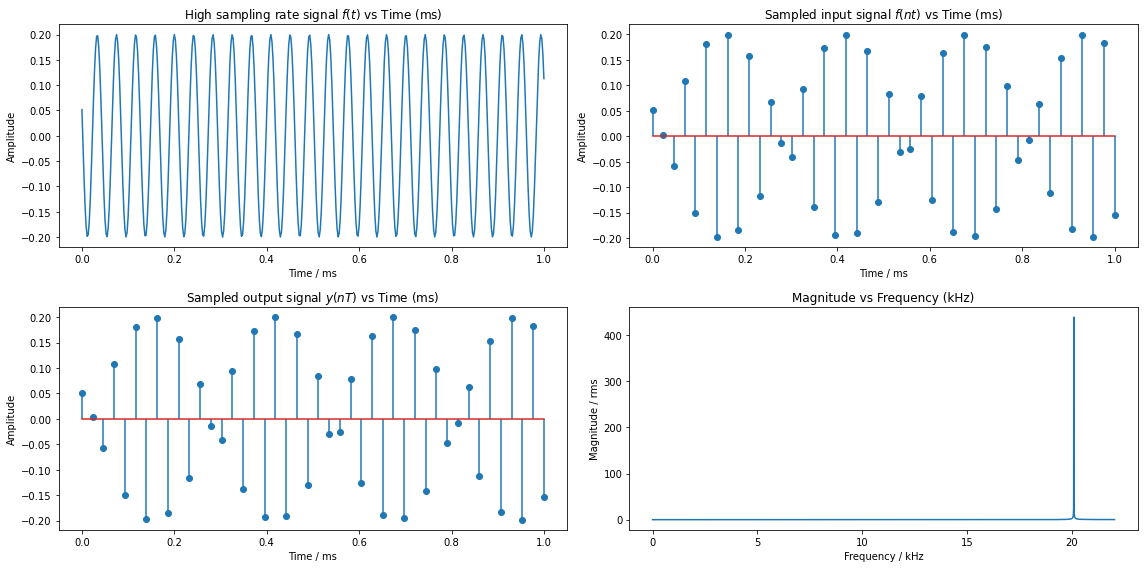

In [9]:
f_t = create_sinusoid(f,fs_high)
f_nT = sampling(f_t)
y_nT = f_nT
figure(figsize=(16,8))
subplot(2,2,1)
time_domain_display_plot(f_t)
title("High sampling rate signal $f(t)$ vs Time (ms)")
subplot(2,2,2)
time_domain_display_stem(f_nT)
title("Sampled input signal $f(nt)$ vs Time (ms)")
subplot(2,2,3)
time_domain_display_stem(y_nT)
title("Sampled output signal $y(nT)$ vs Time (ms)")
subplot(2,2,4) 
freq_domain_display(f_nT)
tight_layout()

### 1.3 Does the output $y(nT)$ resemble the input signal $f(t)$ ? If not, then explain the difference. 

Now try different frequencies in the 20 kHz to 24 kHz range making sure to also try 22.05 kHz.

In [10]:
f = 30000 # Hz 

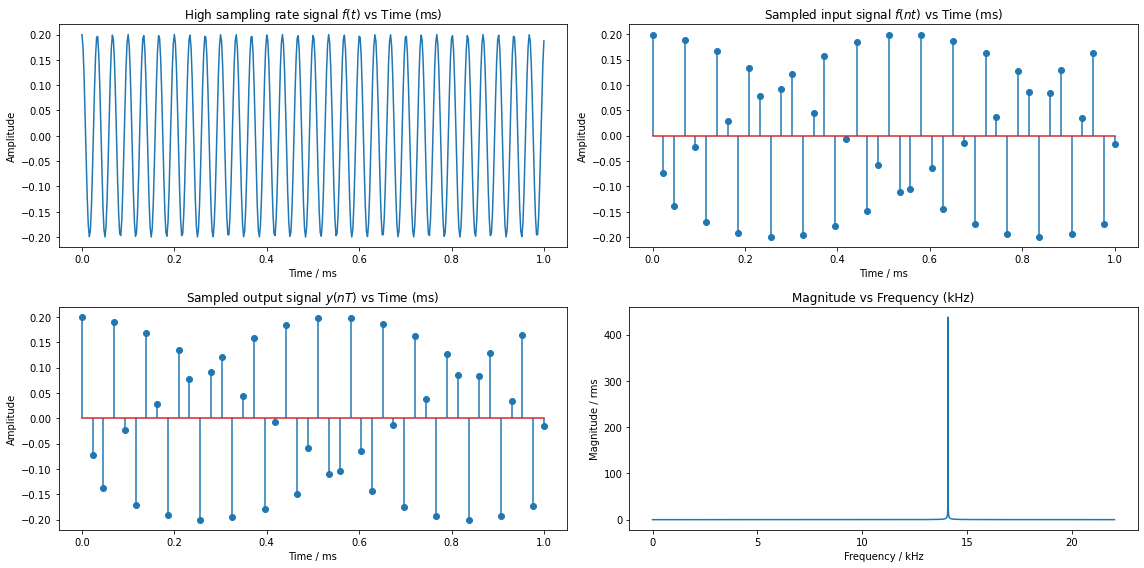

In [11]:
f_t = create_sinusoid(f,fs_high)
f_nT = sampling(f_t)
y_nT = f_nT
figure(figsize=(16,8))
subplot(2,2,1)
time_domain_display_plot(f_t)
title("High sampling rate signal $f(t)$ vs Time (ms)")
subplot(2,2,2)
time_domain_display_stem(f_nT)
title("Sampled input signal $f(nt)$ vs Time (ms)")
subplot(2,2,3)
time_domain_display_stem(y_nT)
title("Sampled output signal $y(nT)$ vs Time (ms)")
subplot(2,2,4) 
freq_domain_display(f_nT)
tight_layout()

### 1.4 Describe what happens to the output signal in the time and frequency domain. 

### 1.5 At 24 kHz, does the output $y(nT)$ resemble the input signal $f(t)$ or do we have an aliased component ? 

### 1.6 What is the significance of the frequency 22.05 kHz ? Remember the sampling rate is 44100 Hz.

### 1.7 Finally increase the input frequency from 24 to 30 kHz. What do you observe ? Explain what is happening. 

# 2. Digital Filtering

In this section we set our System as a digital band pass filter and examine its effect on input signals.

To apply a IF band pass filter, let's first create a band pass filter and you may observe its frequency response using the function freq_response(), which is provided in the cells below. The default cutoff frequencies are 6 kHz and 9 kHz, feel free to change the parameters fc_low and fc_high to see different frequency response.

In [12]:
fc_low = 6*1000 
fc_high = 9*1000 
taps = create_bandpass_filter(fc_low,fc_high)

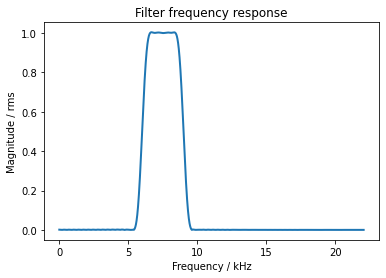

In [13]:
freq_response(taps)

Now let's create a 1.5 kHz square wave and use the band pass filter created above as the System. 

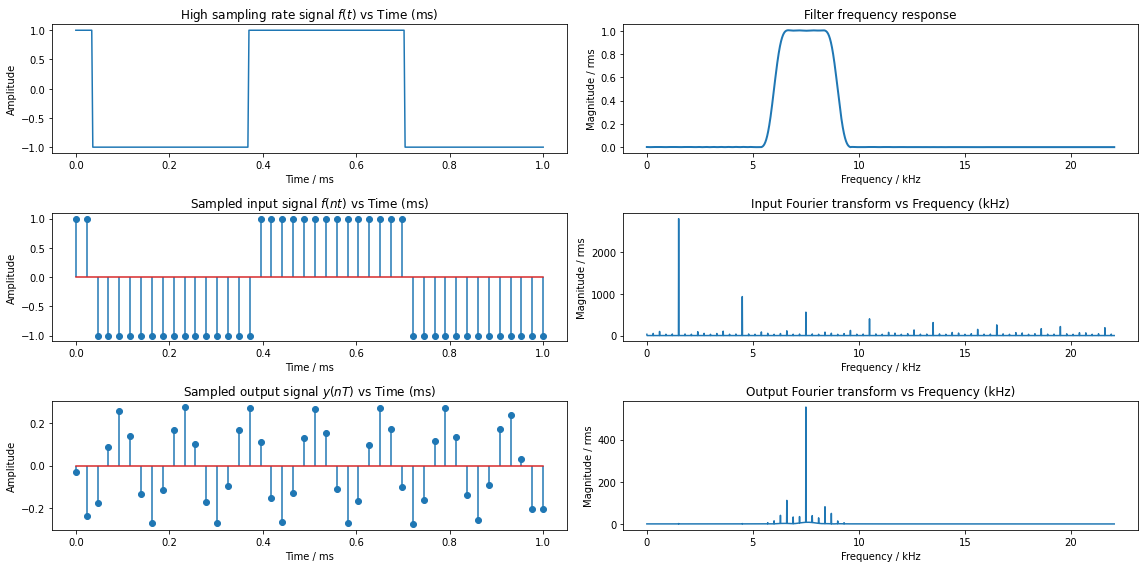

In [14]:
f =1500  # Hz,
f_t = create_square(f,fs_high)
f_nT = sampling(f_t)
y_nT = lfilter(taps,1,f_nT)
figure(figsize=(16,8))
subplot(3,2,1)
time_domain_display_plot(f_t)
title("High sampling rate signal $f(t)$ vs Time (ms)")
subplot(3,2,2)
freq_response(taps)
subplot(3,2,3)
time_domain_display_stem(f_nT)
title("Sampled input signal $f(nt)$ vs Time (ms)")
subplot(3,2,4) 
freq_domain_display(f_nT)
title("Input Fourier transform vs Frequency (kHz)")
subplot(3,2,5)
time_domain_display_stem(y_nT)
title("Sampled output signal $y(nT)$ vs Time (ms)")
subplot(3,2,6) 
freq_domain_display(y_nT)
title("Output Fourier transform vs Frequency (kHz)")
tight_layout()

### 2.1 What is the frequency of the output $y(t)$ ? 

### 2.2 Explain why do you have such output, when the input is a 1.5 kHz square wave. (Hint: Having in mind the analysis of the perodic square wave done in lab 3, recall that the input signal should consist on decreasing odd harmonics of the fundamental frequency.)

Now let's examine a square wave with frequency of 13 kHz without any filtering (that is, using an "all pass")

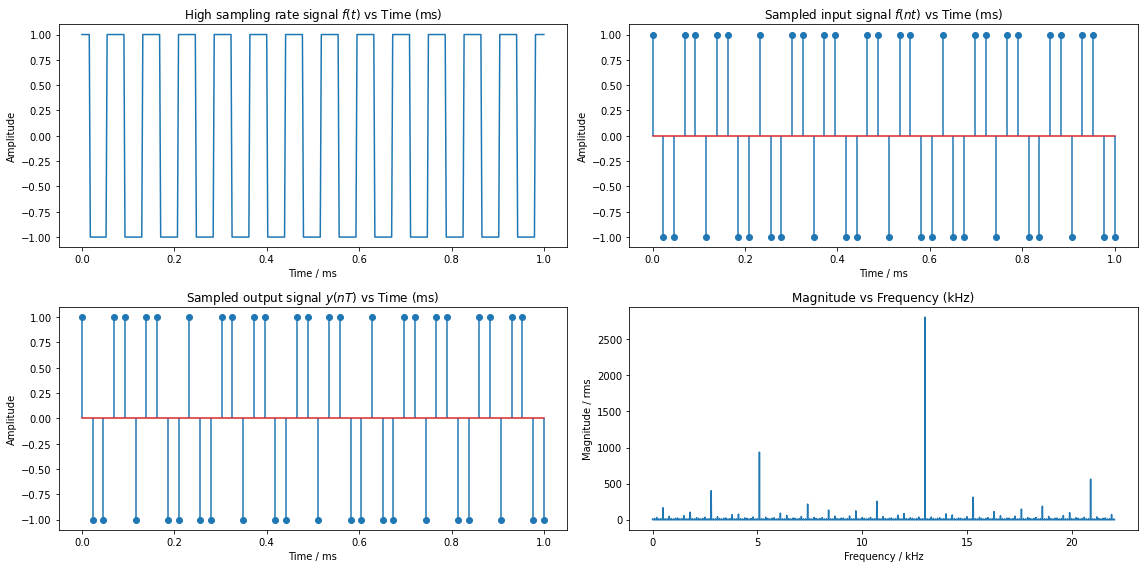

In [15]:
f = 13000 # Hz
f_t = create_square(f,fs_high)
f_nT = sampling(f_t)
y_nT = f_nT
figure(figsize=(16,8))
subplot(2,2,1)
time_domain_display_plot(f_t)
title("High sampling rate signal $f(t)$ vs Time (ms)")
subplot(2,2,2)
time_domain_display_stem(f_nT)
title("Sampled input signal $f(nt)$ vs Time (ms)")
subplot(2,2,3)
time_domain_display_stem(y_nT)
title("Sampled output signal $y(nT)$ vs Time (ms)")
subplot(2,2,4) 
freq_domain_display(f_nT)
tight_layout()

### 2.3 Explain why the second largest frequency component is around 5 kHz.

# 3. Receiving Synthetic AM

Now let's examine the synthetic AM signal. First let's create AM signal using the utility function and observe its Fourier transform after sampling. The System is set to be "all pass".  

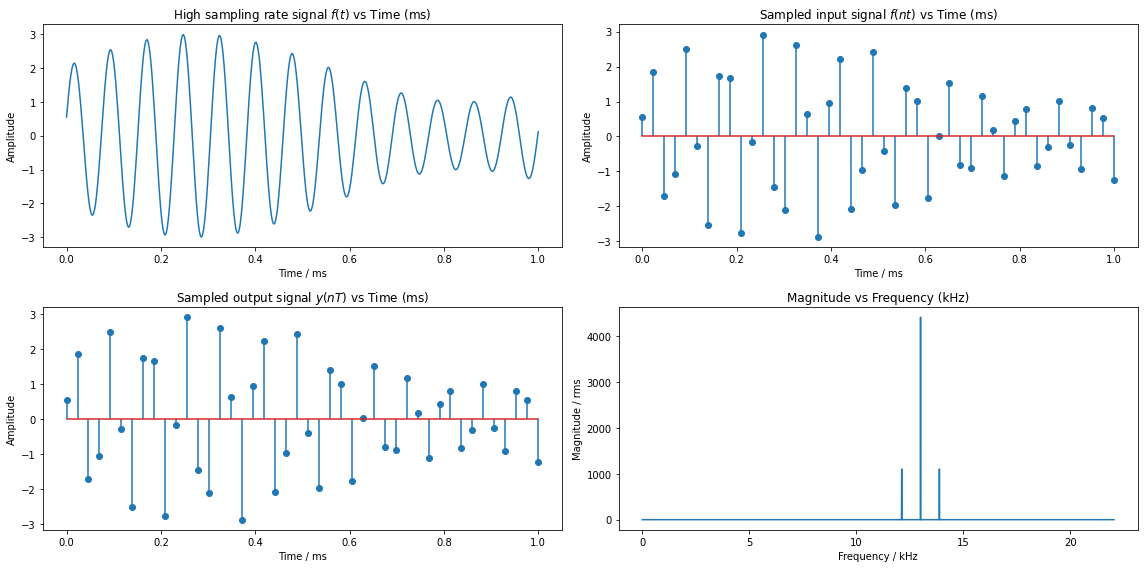

In [16]:
f_c = 13000 # Hz
f_m = 880
f_t = create_AM(f_c,f_m)
f_nT = sampling(f_t)
y_nT = f_nT
figure(figsize=(16,8))
subplot(2,2,1)
time_domain_display_plot(f_t)
title("High sampling rate signal $f(t)$ vs Time (ms)")
subplot(2,2,2)
time_domain_display_stem(f_nT)
title("Sampled input signal $f(nt)$ vs Time (ms)")
subplot(2,2,3)
time_domain_display_stem(y_nT)
title("Sampled output signal $y(nT)$ vs Time (ms)")
subplot(2,2,4) 
freq_domain_display(f_nT)
tight_layout()

### 3.1 What does the strong impulse at $f=13$ kHz represent in this AM signal. 

### 3.2 At what frequency locations are the other two impulses surrounding the 13 kHz impulse, and what do they represent ? 

Recall in lab 3, we built a band pass and filter using capacitor and resistors. This time we will implement the same band pass filter in digital domain with cutoff frequencies of 8 kHz and 18 kHz. 

In [20]:
fc_low = 8*1000 
fc_high = 18*1000 
taps = create_bandpass_filter(fc_low,fc_high)

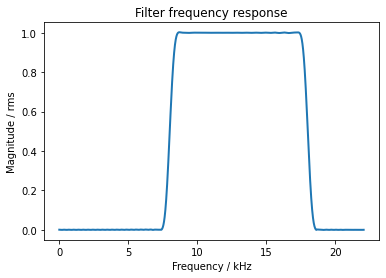

In [21]:
freq_response(taps)

### 3.3 Compare the frequency response of the digital band pass filter with the frequency response of the analog band pass filter built in lab 3, which one is considered a better filter and why ? 

Now let's apply this band pass filter to the synthetic AM signal.

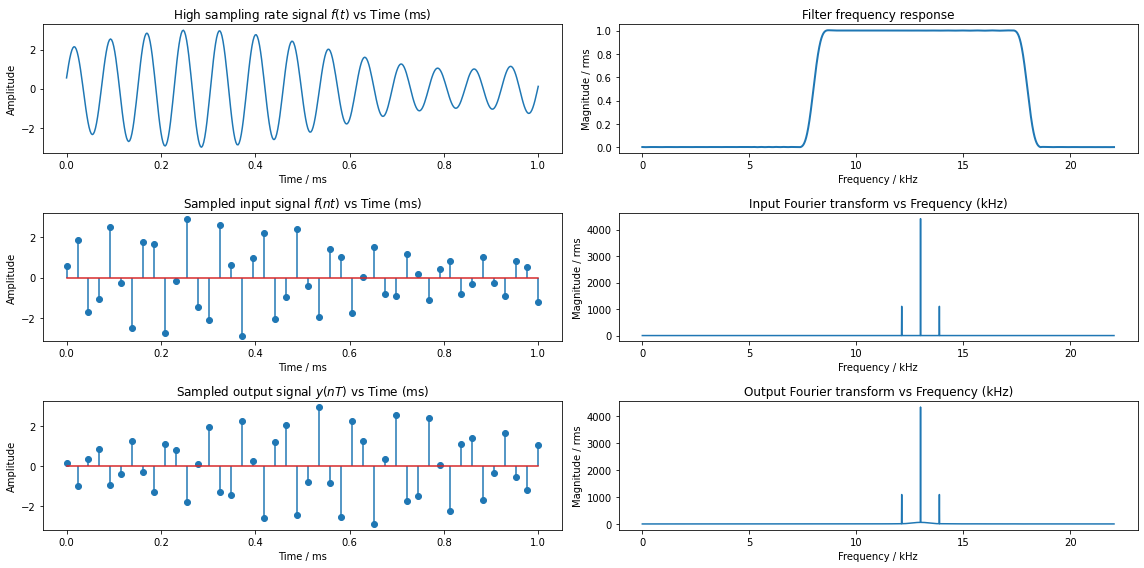

In [22]:
f_nT = sampling(f_t)
y_nT = lfilter(taps,1,f_nT)
figure(figsize=(16,8))
subplot(3,2,1)
time_domain_display_plot(f_t)
title("High sampling rate signal $f(t)$ vs Time (ms)")
subplot(3,2,2)
freq_response(taps)
subplot(3,2,3)
time_domain_display_stem(f_nT)
title("Sampled input signal $f(nt)$ vs Time (ms)")
subplot(3,2,4) 
freq_domain_display(f_nT)
title("Input Fourier transform vs Frequency (kHz)")
subplot(3,2,5)
time_domain_display_stem(y_nT)
title("Sampled output signal $y(nT)$ vs Time (ms)")
subplot(3,2,6) 
freq_domain_display(y_nT)
title("Output Fourier transform vs Frequency (kHz)")
tight_layout()

Not surprising, the output is almost the same as the input because the major frequency components pass through the filter without much changing. However, this filter would be much useful for a broader bandwidth signal as you may see in the next section. 

Now let's observe the output of a envelope detector after the band pass fitler. The System now is a combination of band pass filter and envelope detector.

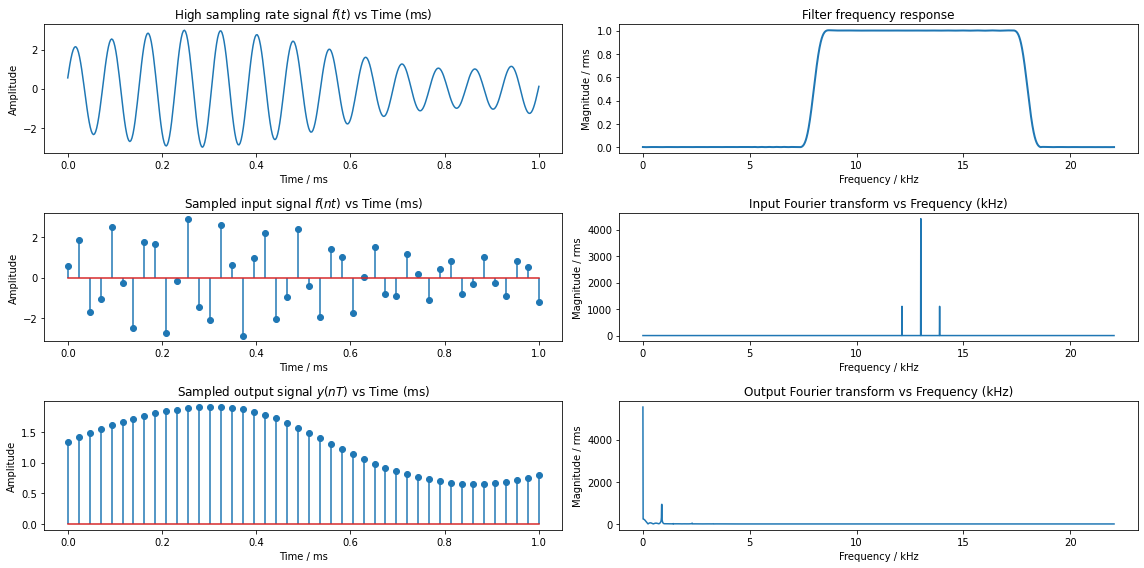

In [23]:
f_nT = sampling(f_t)
filtered_signal = lfilter(taps,1,f_nT)
y_nT = Envelope_Detector(filtered_signal)

figure(figsize=(16,8))
subplot(3,2,1)
time_domain_display_plot(f_t)
title("High sampling rate signal $f(t)$ vs Time (ms)")
subplot(3,2,2)
freq_response(taps)
subplot(3,2,3)
time_domain_display_stem(f_nT)
title("Sampled input signal $f(nt)$ vs Time (ms)")
subplot(3,2,4) 
freq_domain_display(f_nT)
title("Input Fourier transform vs Frequency (kHz)")
subplot(3,2,5)
time_domain_display_stem(y_nT)
title("Sampled output signal $y(nT)$ vs Time (ms)")
subplot(3,2,6) 
freq_domain_display(y_nT)
title("Output Fourier transform vs Frequency (kHz)")
tight_layout()

### 3.4 In the time domain, what type of signal is that. Describe it. And in the frequency domain, can you find the message signal ? 

Besides envelope detector, there is another type called coherent detector. A coherent detector works as follows. For a received signal of the form $m(t)\cos(\omega_c t+\theta_0)$, the carrier frequency $\omega_c$ and the pase delay $\theta_0$ are estimated. THen a cosine signal with the same carrier frequency and phase delay is generated and mixed with the received signal, yielding $m(t)\cos(\omega_c t+\theta_0)\cos(\omega_c t+\theta_0)=m(t)\cos^2(\omega_c t+\theta_0)=\frac{1}{2}m(t)(1+\cos(2\omega_c t))$. Finally a lowpass filter is applied to filter out the $2\omega_c$ modulated signal in order to obtain the message $m(t)$.

Now let's observe the output of a coherent detector after the band pass fitler. The System now is a combination of band pass filter and coherent detector.

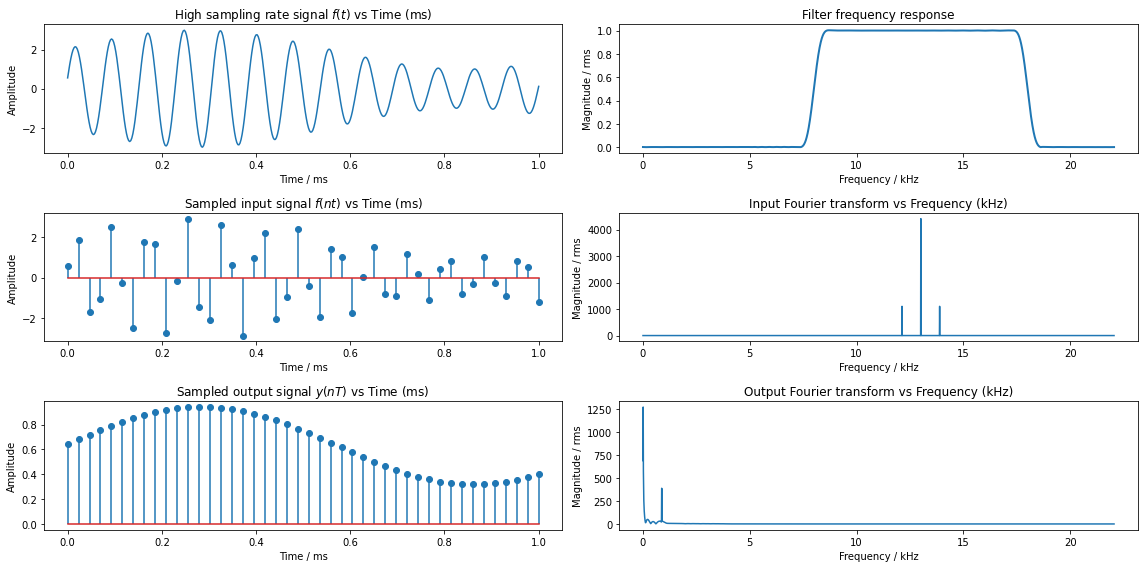

In [24]:
f_nT = sampling(f_t)
filtered_signal = lfilter(taps,1,f_nT)
y_nT = Coherent_Detector(filtered_signal)

figure(figsize=(16,8))
subplot(3,2,1)
time_domain_display_plot(f_t)
title("High sampling rate signal $f(t)$ vs Time (ms)")
subplot(3,2,2)
freq_response(taps)
subplot(3,2,3)
time_domain_display_stem(f_nT)
title("Sampled input signal $f(nt)$ vs Time (ms)")
subplot(3,2,4) 
freq_domain_display(f_nT)
title("Input Fourier transform vs Frequency (kHz)")
subplot(3,2,5)
time_domain_display_stem(y_nT)
title("Sampled output signal $y(nT)$ vs Time (ms)")
subplot(3,2,6) 
freq_domain_display(y_nT)
title("Output Fourier transform vs Frequency (kHz)")
tight_layout()

### 3.5 Overall, what does the envelope detector or the coherent detector accomplish ? 

# 4.Receiving recorded AM 

In this last section, you will process the recorded AM signal with our system and eventually listen to its detected version. 

Load the same recorded file as in lab 4, and we will apply the band pass fitler with cutoff frequencies of 10 kHz and 18 kHz. Note that the recorded file is already sampled so we will skip the sampling in the system diagram. 

There are some choices of recorded files, please choose from 'recorded_AM_1.wav' ,'recorded_AM_2.wav' ,'recorded_AM_3.wav' ,'recorded_AM_4.wav' in the next cell.

In [25]:
file_name = 'recorded_AM_1.wav' # other options are available 

In [26]:
fs, wave_test = wavfile.read(file_name)
audio_signal = wave_test/2**16
fc_low = 10*1000 
fc_high = 18*1000 
taps = create_bandpass_filter(fc_low,fc_high)

In [27]:
Audio(audio_signal, rate=fs)

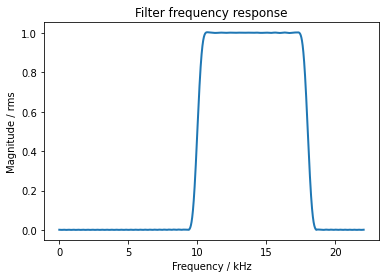

In [28]:
freq_response(taps)

Next we will examine our band pass filter on the sampled AM signal. Note that to examine the subtle difference, we use dB for the magnitude display in spectrum. 

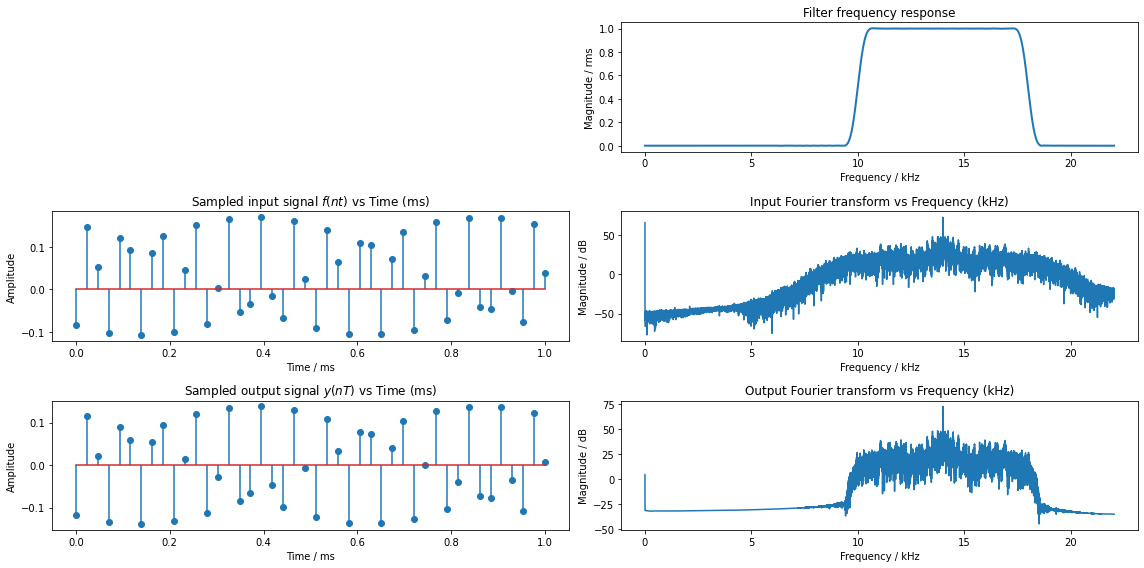

In [30]:
f_nT = audio_signal
filtered_signal = lfilter(taps,1,f_nT)
y_nT = filtered_signal
figure(figsize=(16,8))
subplot(3,2,2)
freq_response(taps)
subplot(3,2,3)
time_domain_display_stem(f_nT)
title("Sampled input signal $f(nt)$ vs Time (ms)")
subplot(3,2,4) 
freq_domain_display(f_nT,unit="dB")
title("Input Fourier transform vs Frequency (kHz)")
subplot(3,2,5)
time_domain_display_stem(y_nT)
title("Sampled output signal $y(nT)$ vs Time (ms)")
subplot(3,2,6) 
freq_domain_display(y_nT,unit="dB")
title("Output Fourier transform vs Frequency (kHz)")
tight_layout()

### 4.1 In the spectrum of input, what is the frequency of the peak and what does it represent ? 

### 4.2 Approximately what is the bandwidth of the output signal ? Does it align with the frequency response of the band pass filter ? 

Now let's add envelope detector to the system.

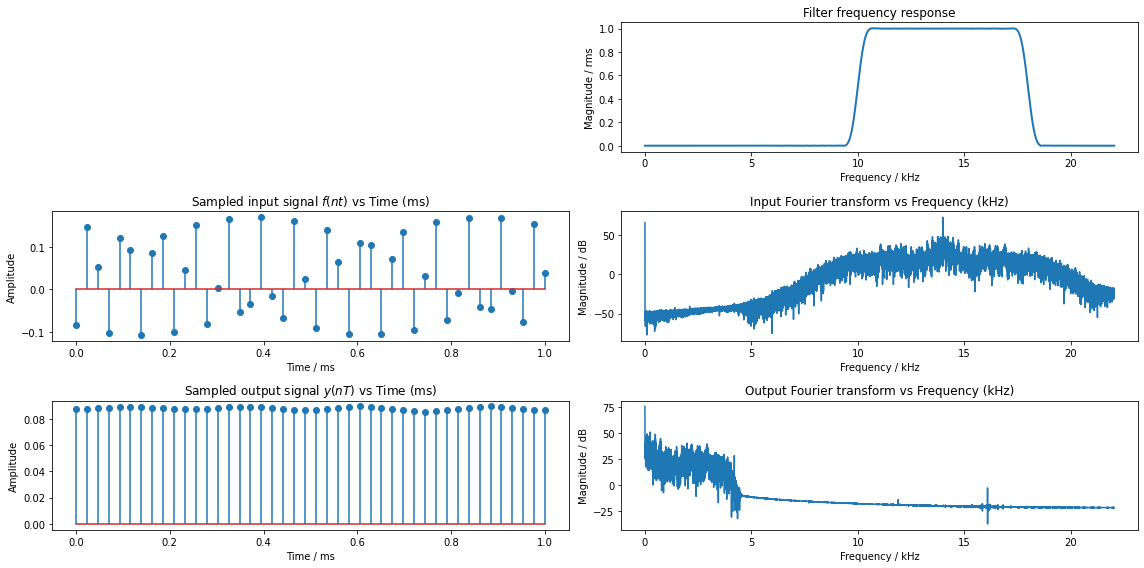

In [31]:
f_nT = audio_signal
filtered_signal = lfilter(taps,1,f_nT)
y_nT = Envelope_Detector(filtered_signal)
figure(figsize=(16,8))
subplot(3,2,2)
freq_response(taps)
subplot(3,2,3)
time_domain_display_stem(f_nT)
title("Sampled input signal $f(nt)$ vs Time (ms)")
subplot(3,2,4) 
freq_domain_display(f_nT,unit="dB")
title("Input Fourier transform vs Frequency (kHz)")
subplot(3,2,5)
time_domain_display_stem(y_nT)
title("Sampled output signal $y(nT)$ vs Time (ms)")
subplot(3,2,6) 
freq_domain_display(y_nT,unit="dB")
title("Output Fourier transform vs Frequency (kHz)")
tight_layout()

You may verify the result above by listening to the output signal. To do that, you may use the next cell to create a widget that plays the audio for you.

In [32]:
Audio(y_nT, rate = fs)

### 4.3 Did you successfully demodulate the AM signal ? How was it compare to the one you did with circuit ?  Explain the advantage of digital filter. 